In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

# Design space exploration

Beyond the most trivial problems, the design space is a complex high-dimensional space filled with many local minima and maxima. Navigating this space in search of optimal or feasible solutions is a non-trivial task. In many engineering applications, evaluating the objective function at a single point requires running a computationally expensive simulation, which can take anywhere from hours to days to complete. Consequently, it is imperative to search the design space efficiently.

In this notebook, we visually demonstrate various concepts using a 2D design space defined by parameters $X_1$ and $X_2$, alongside a known objective function shape $f(X_1, X_2)$. Users can select the objective function shape from a variety of examples, including *double-banana-shaped distributions* and multi-modal Gaussian distributions.

The following concepts are elucidated:

- **Grid Search**: A straightforward exploration method that evaluates points on a grid. While easy to implement, it suffers from the curse of dimensionality, making it inefficient in high-dimensional spaces.

- **Monte Carlo Sampling**: A statistical method that randomly samples points in the design space. It offers a way to explore large areas quickly but may not focus on the most promising regions.

- **Optimisation**: The objective of optimisation is to identify the best solution according to a specified objective function. It involves systematically searching for the global maximum or minimum.

- **Markov Chain Monte Carlo (MCMC)**: MCMC samplers navigate the design space by producing samples that are preferentially drawn from areas of higher probability or likelihood. This method effectively focuses the exploration on the most promising design solutions.

## Design space

**Banana:**

Below is a simple implementation of a banana-shaped posterior distribution. This function creates a banana-shaped posterior distribution by combining a quadratic term $(x_2 - x_1^2)^2$ with a Gaussian-like term $(x_1 - 2)^2$, exponentiated to ensure positivity. Adjusting the coefficients and terms can modify the shape and size of the "banana".

In [2]:
def banana(x):
    x1, x2 = x
    return np.exp(-0.1 * ((x2 - x1**2) ** 2 + (x1 - 2) ** 2))

In [3]:
def double_banana(x, peaks=(1.0, 1.5), offsets=(0.0, 6.0), scales=(0.1, 0.2), curvatures=(-1, 1)):
    x1, x2 = x
    bananas = [
        peak * np.exp(-scale * ((x2 - curvature * (x1 - offset)**2) ** 2 + (x1 - offset - 2) ** 2))
        for peak, offset, scale, curvature in zip(peaks, offsets, scales, curvatures)
    ]
    return sum(bananas)

In [4]:
def weighted_multi_gaussian_mixture(x):
    x1, x2 = x
    means = [(0, 0), (2, 7), (5, 4)]
    stds = [1.5, 0.5, 1]
    weights = [0.3, 0.8, 0.2]
    return sum(
        w * np.exp(-((x1 - mean[0]) ** 2 + (x2 - mean[1]) ** 2) / (2 * std**2))
        for mean, std, w in zip(means, stds, weights)
    )

In [5]:
design_space = double_banana

8.013013013013014 4.06406406406407


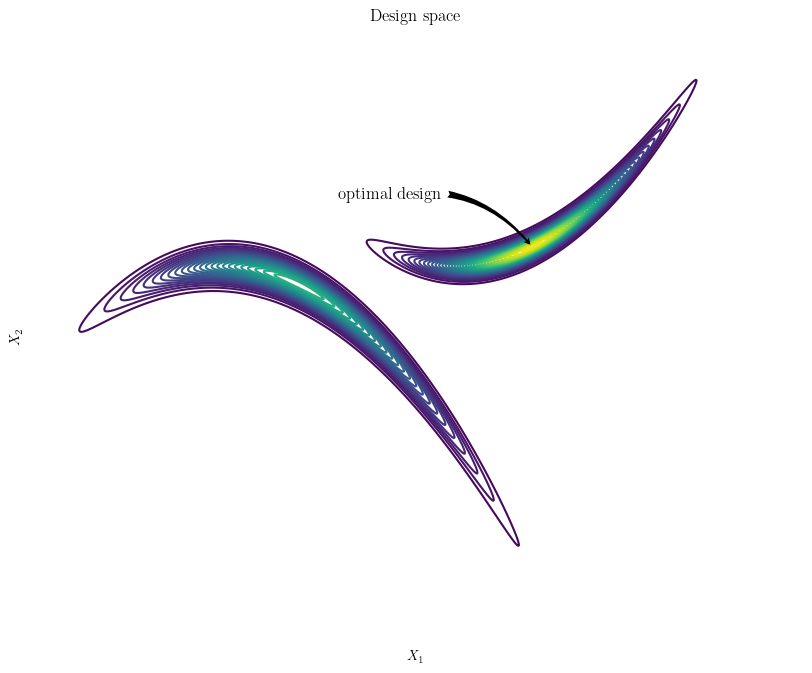

In [6]:
x1_range = np.linspace(-5, 15, 1000)
x2_range = np.linspace(-80, 50, 1000)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.array([[design_space((x1, x2)) for x1 in x1_range] for x2 in x2_range])
Z = np.where(Z > 0.01, Z, np.nan)

max_index = np.unravel_index(np.nanargmax(Z), Z.shape)
x1_max, x2_max = X1[max_index], X2[max_index]
print(x1_max, x2_max)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])

plt.annotate(
    'optimal design',
    xy=(x1_max, x2_max),
    xytext=(x1_max - 5, x2_max + 10),
    fontsize=12,
    ha='left',
    color='black',
    arrowprops=dict(
        arrowstyle='fancy',
        connectionstyle='arc3,rad=-0.3',
        facecolor='black',
        edgecolor='none'
    )
)

plt.savefig('design-space.png', dpi=300, bbox_inches='tight')

## Grid search

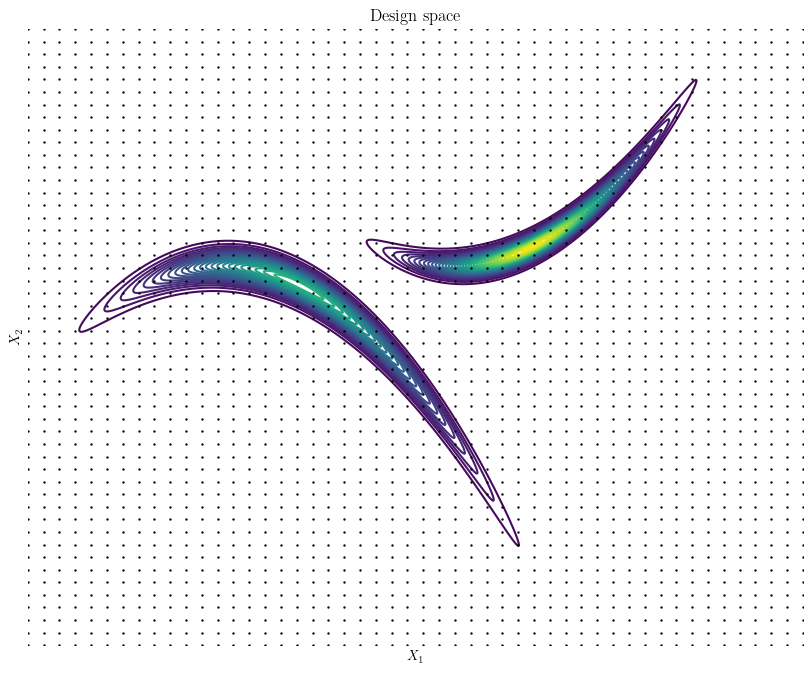

In [7]:
x1_search = np.linspace(-5, 15, 50)
x2_search = np.linspace(-80, 50, 50)
X1_search, X2_search = np.meshgrid(x1_search, x2_search)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(X1_search, X2_search, s=0.5, color='black', zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('grid-search.png', dpi=300, bbox_inches='tight')

## Monte Carlo

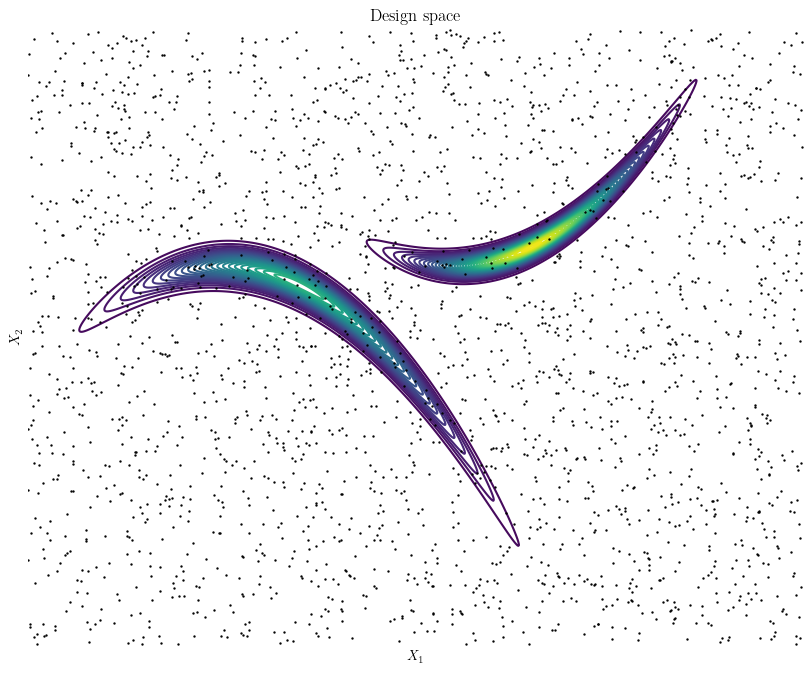

In [8]:
X1_mc = np.random.uniform(-5, 15, 2500)
X2_mc = np.random.uniform(-80, 50, 2500)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(X1_mc, X2_mc, s=0.5, color='black', zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('monte-carlo.png', dpi=300, bbox_inches='tight')

## Adaptive Metropolis Hastings (`Sampler` and `Proposal` class)

In [9]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))


class MetropolisHastings(Sampler):
    pass

In [10]:
class Proposal:
    """
    Proposal class

    TODO: look at pysampler/proposal.py
    """

    def __init__(self, step_size):
        self.step_size = step_size

    def draw(self, samples):
        return np.random.normal(samples[-1], self.step_size)


class GaussianProposal(Proposal):
    pass


class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [11]:
class Posterior:

    def __init__(self, distribution):
        self.distribution = distribution

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.distribution(x)

In [12]:
posterior = Posterior(distribution=design_space)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 27151.08it/s]


In [13]:
def scatter_hist(x, y, p, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.scatter(x, y, s=1, c=p)

    xbinwidth = (np.max(x) - np.min(x)) / 100
    ybinwidth = (np.max(y) - np.min(y)) / 100
    xbins = np.arange(np.min(x), np.max(x) + xbinwidth, xbinwidth)
    ybins = np.arange(np.min(y), np.max(y) + ybinwidth, ybinwidth)
    ax_histx.hist(x, bins=xbins, density=True, histtype="step")
    ax_histy.hist(
        y, bins=ybins, density=True, histtype="step", orientation="horizontal"
    )

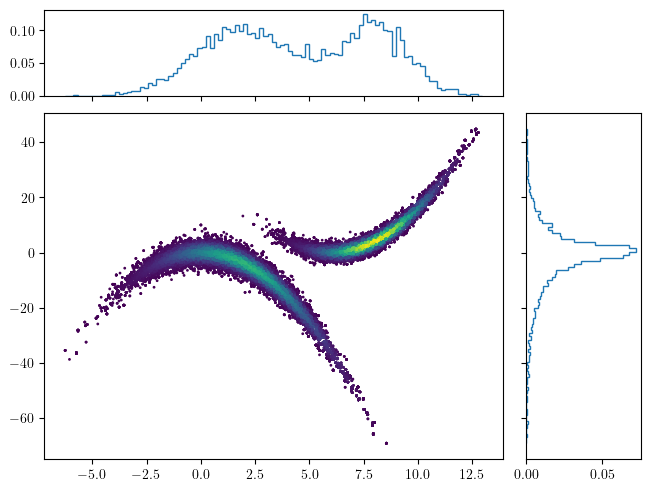

In [14]:
fig = plt.figure(layout="constrained")
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [
    posterior.evaluate(sample) for sample in samples
]  # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

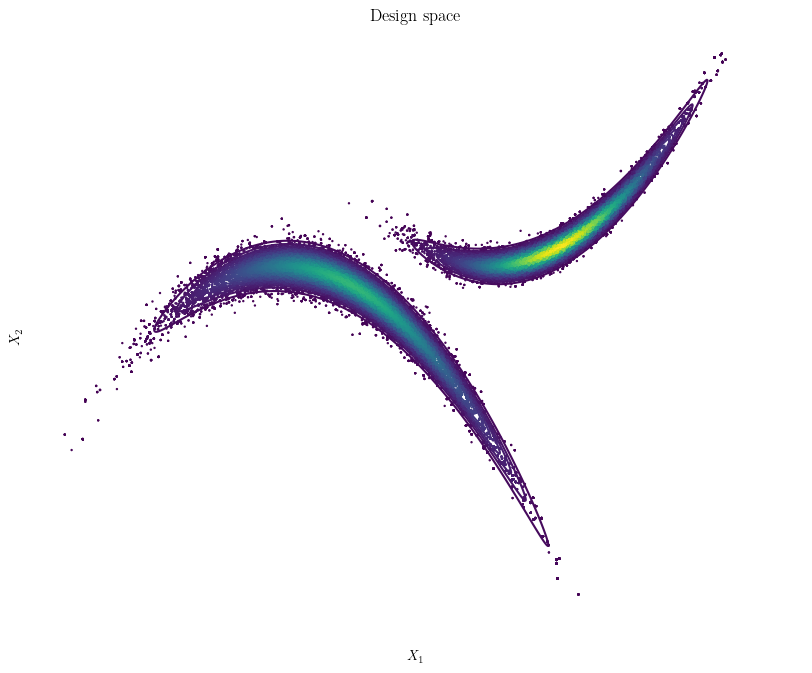

In [15]:
plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(samples[:, 0], samples[:, 1], c=p, s=0.5, zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('mcmc.png', dpi=300, bbox_inches='tight')

## Gradient-based optimisation

In [16]:
class GradientDescent:

    def __init__(self, posterior, initial_candidate):
        self.posterior = posterior
        self.candidate = initial_candidate

    def optimise(self, step_size, n_steps=100):
        """
        Optimise the cost function using gradient descent.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.

        Returns:
        """
        cost_hist = []
        candidate_hist = []

        for _ in range(n_steps):
            gradient = self._compute_gradient()
            self.candidate -= step_size * gradient
            candidate_hist.append(np.copy(self.candidate))
            cost_hist.append(self._cost_function(self.candidate))

        return np.array(candidate_hist), cost_hist

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return self.posterior.evaluate(candidate)

In [17]:
class GradientDescent:

    def __init__(self, posterior, initial_candidate_range, num_random_starts=5):
        
        self.posterior = posterior
        self.initial_candidate_range = initial_candidate_range
        self.num_random_starts = num_random_starts
        self.num_parameters = len(initial_candidate_range)

    def optimise(self, step_size, n_steps=100, momentum=0.9):
        """
        Optimise the cost function using stochastic gradient descent with momentum.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.
        momentum (float): Momentum factor.
        batch_size (int): Number of data points to use in each mini-batch.

        Returns:
        """
        best_candidate = None
        best_cost = float('inf')
        best_candidate_hist = None
        best_cost_hist = None

        for _ in range(self.num_random_starts):

            self.candidate = self._initialise_candidate()
            
            cost_hist = []
            candidate_hist = []
            velocity = np.zeros_like(self.candidate)

            for _ in range(n_steps):
                gradient = self._compute_gradient()
                velocity = momentum * velocity - step_size * gradient
                self.candidate += velocity
                candidate_hist.append(np.copy(self.candidate))
                cost = self._cost_function(self.candidate)
                cost_hist.append(cost)

            if cost_hist[-1] < best_cost:
                best_cost = cost_hist[-1]
                best_candidate = np.copy(self.candidate)
                best_candidate_hist = candidate_hist
                best_cost_hist = cost_hist

        return np.array(best_candidate_hist), np.array(best_cost_hist)

    def _initialise_candidate(self):
        return np.array([np.random.uniform(lower_bound, upper_bound) 
                         for lower_bound, upper_bound in self.initial_candidate_range])

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return -self.posterior.evaluate(candidate)

In [18]:
X1_init_range = np.array([0, 5])
X2_init_range = np.array([-60, 30])
initial_params = [X1_init_range, X2_init_range]

optimiser = GradientDescent(posterior, initial_params, num_random_starts=5)
candidate_hist, cost_hist = optimiser.optimise(step_size=np.array([0.1, 0.1]), n_steps=100000)

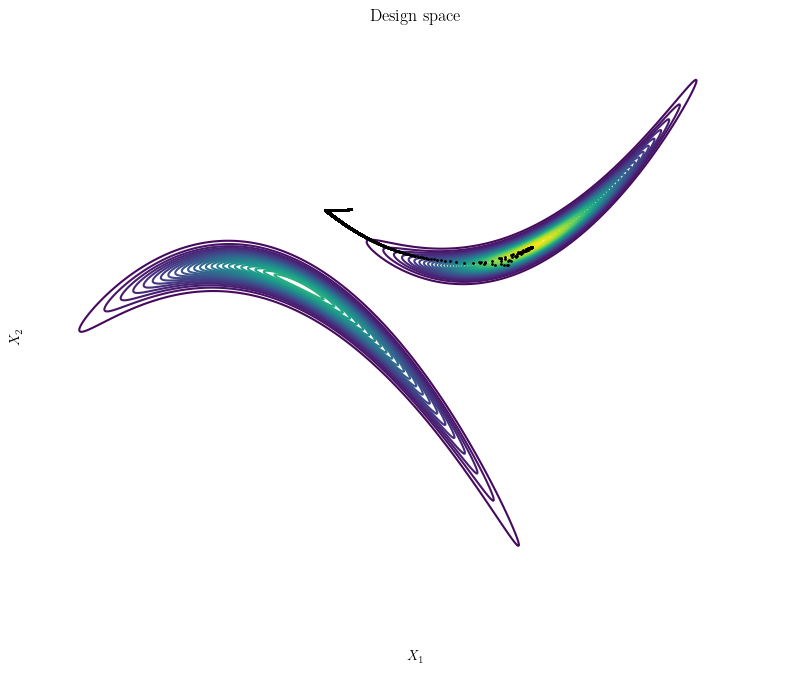

In [19]:
plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(candidate_hist[:, 0], candidate_hist[:, 1], s=1, color='black', zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('optimisation.png', dpi=300, bbox_inches='tight')

## Genetic algorithm

In [20]:
import random
from tqdm import tqdm

class GeneticAlgorithm:
    def __init__(
        self,
        population,
        num_generations=50,
        num_parents=4,
        mutation_probability=0.05,
        animate=False,
    ):
        self.population = population
        self.num_generations = num_generations
        self.num_parents = num_parents
        self.mutation_probability = mutation_probability
        self.animate = animate
        if self.animate:
            self.animation = Animation()
            self.animation.save_frame(self.population)
        self.fitness = []

    def generate_offspring(self):
        new_population = []
        for _ in range(len(self.population.individuals)):
            parent_a, parent_b = random.sample(self.population.parents, 2)
            child = parent_a.crossover(parent_b)
            child.mutate(self.mutation_probability)
            new_population.append(child)

        self.population.individuals = new_population

    def evolutionary_cycle(self):
        self.population.evaluate()
        self.fitness.append(max(self.population.fitness))
        self.population.select_parents(self.num_parents)
        self.generate_offspring()
        if self.animate:
            self.animation.save_frame(self.population)

    def evolve(self):
        for _ in tqdm(range(self.num_generations), desc="Evolution"):
            self.evolutionary_cycle()

        if self.animate:
            self.animation.generate()

    def plot_fitness(self):
        _, ax = plt.subplots(figsize=(8, 4))
        ax.plot(self.fitness)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness Evolution")
        ax.grid(True)
        plt.tight_layout()

In [21]:
class Population:

    def __init__(self, individuals):
        self.individuals = individuals
        self.fitness = []
        self.parents = []

    def evaluate(self):
        self.fitness = [individual.fitness() for individual in self.individuals]

    def select_parents(self, num_parents):
        self.parents = sorted(
            self.individuals, key=lambda x: x.fitness(), reverse=True
        )[:num_parents]

    def plot(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for individual in self.individuals:
            individual.plot(ax)
        plt.tight_layout()
        return fig

In [22]:
class Individual:
    def __init__(self, genes):
        self.genes = genes
        self._fitness = None

    def evaluate_fitness(self):
        """
        This method should be implemented in subclasses to evaluate fitness.
        """
        raise NotImplementedError

    def fitness(self):
        """
        Returns the fitness of the individual. Computes fitness if it has not
        been computed yet.
        """
        if self._fitness is None:
            self.evaluate_fitness()
        return self._fitness

    def crossover(self, partner, alpha=0.5):
        """
        Blend Crossover (BLX-alpha)

        Parameters
        ----------
        partner : Individual
            The other parent individual.
        alpha : float
            The blending parameter that controls the range of crossover.

        Returns
        -------
        child : Individual
            The offspring produced by crossover.
        """
        child = np.zeros_like(self.genes)
        for i in range(len(self.genes)):
            X_min = min(self.genes[i], partner.genes[i])
            X_max = max(self.genes[i], partner.genes[i])
            delta = X_max - X_min
            child[i] = np.random.uniform(X_min - alpha * delta,
                                         X_max + alpha * delta)
        return child

    def mutate(self, mutation_probability, sigma=0.1):
        """
        Gaussian Mutation

        Parameters
        ----------
        mutation_probability : float
            The probability of mutating each gene.
        sigma : float
            The standard deviation of the Gaussian distribution 
            used for mutation.

        Returns
        -------
        None
        """
        for i in range(len(self.genes)):
            if np.random.rand() < mutation_probability:
                self.genes[i] += np.random.normal(0, sigma)

In [23]:
class Design(Individual):
    def __init__(self, genes, posterior):
        super().__init__(genes)
        self.posterior = posterior

    def evaluate_fitness(self):
        self._fitness = self.posterior.evaluate(self.genes)

    def crossover(self, partner):
        return Design(super().crossover(partner), self.posterior)
        
    def mutate(self, mutation_probability):
        super().mutate(mutation_probability)

    def plot(self, ax):
        """
        TODO: plot the posterior here!
        """
        ax.scatter(self.genes[0], self.genes[1], color='black')

In [24]:
from datetime import datetime

import matplotlib.animation as animation

class Animation:
    def __init__(self, name=None):
        self.name = name or self._generate_animation_name()
        self.frames = []

    @staticmethod
    def _generate_animation_name():
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        return f"{timestamp}-animation.gif"
    
    def save_frame(self, population):
        frame_data = [(individual.genes[0], individual.genes[1]) for individual in population.individuals]
        self.frames.append(frame_data)

    def _update(self, frame_data):
        self.ax.clear()
        x_data, y_data = zip(*frame_data)
        self.ax.scatter(x_data, y_data, s=10, color='black', zorder=5)
        self.ax.set_xlabel('X1')
        self.ax.set_ylabel('X2')
        self.ax.set_title(f'Generation {self.frames.index(frame_data) + 1}')
        plt.gca().set_frame_on(False)
        plt.xticks([])
        plt.yticks([])
    
        return self.ax,

    def generate(self, interval=1000, pause=1000):
        """
        Parameters
        ----------
        interval : int, optional
            Time between frames (milliseconds)
            
        pause : int, optional
            Pause at the end of the animation (milliseconds)
        """
        pause_frames = int(pause / interval)
        self.frames.extend([self.frames[-1]] * pause_frames)

        self.fig, self.ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

        self.ani = animation.FuncAnimation(
            self.fig,
            self._update,
            frames=self.frames,
            interval=interval,
            blit=False,
        )

        self.ani.save(self.name, writer=animation.PillowWriter(fps=1000 / interval))

Evolution: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1277.47it/s]


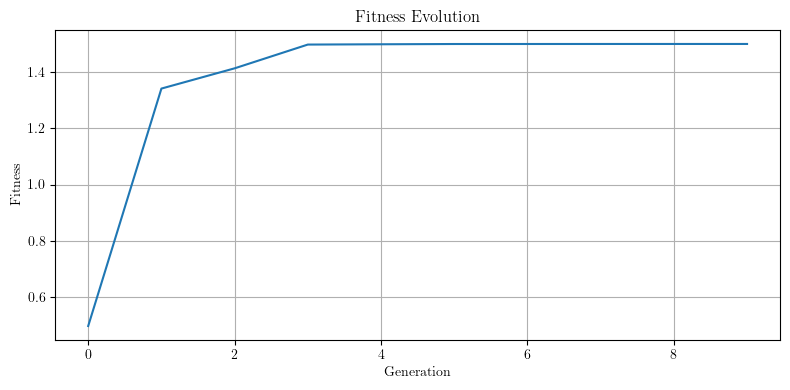

In [25]:
population_size = 100
individuals = [Design(genes=[np.random.uniform(-5, 15), np.random.uniform(-80, 30)], posterior=posterior) 
               for _ in range(population_size)]
population = Population(individuals)

ga = GeneticAlgorithm(population, 
                      num_generations=10, 
                      num_parents=8,
                      mutation_probability=0.05,
                      animate=False)
ga.evolve()
ga.plot_fitness()

## Generative models

Generative models aim to infer the underlying distribution from which observed data is generated. When the data exhibits a non-Gaussian, curved pattern (e.g., a banana distribution), traditional Gaussian Mixture Models (GMMs) may struggle to accurately capture the structure, as they assume linear or elliptical clusters.

More flexible methods are better suited for such cases:

1. **Kernel Density Estimation (KDE)**: A non-parametric method that estimates the probability density function by placing a kernel (e.g., Gaussian) on each data point and summing the contributions, without assuming any specific shape.

2. **Normalising Flows**: These use a series of invertible transformations applied to a simple base distribution (like Gaussian noise) to generate complex, non-Gaussian shapes, effectively capturing intricate data structures.

3. **Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs)**: Deep generative models that learn to map from a latent space to the data space, enabling them to model complex distributions, including highly curved or irregular shapes.

4. **Transformed Gaussian Mixtures**: Applying nonlinear transformations to the data before fitting a GMM can better accommodate curved or non-standard distributions.

While GMMs provide a rough approximation, techniques like KDE, normalising flows, and deep generative models are more suitable for complex high dimensional data. In the engineering domain, deep generative models like GANs and VAEs are used to generate new design candidates by learning the underlying distribution of existing high-performance designs. These models can produce novel design configurations that share desirable characteristics with known solutions.

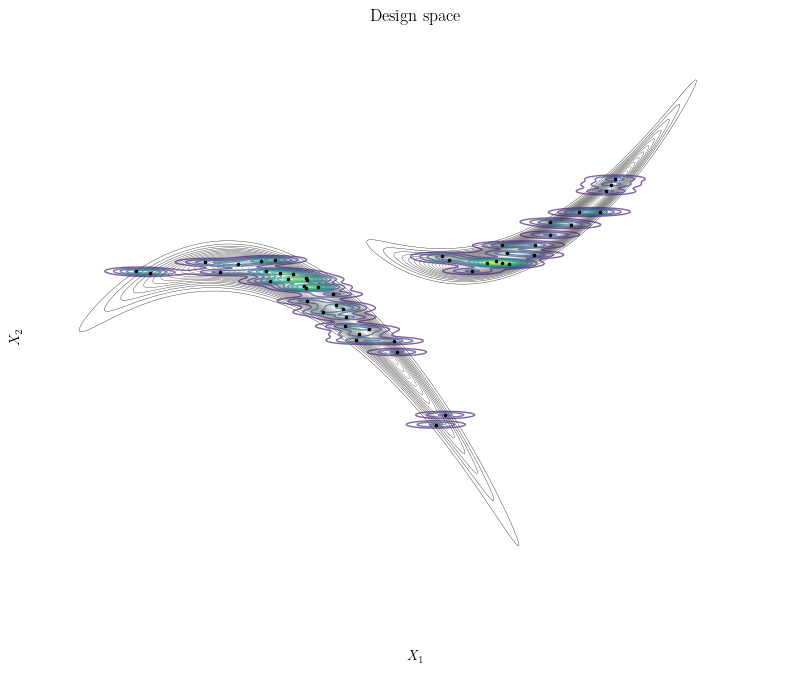

In [26]:
from sklearn.neighbors import KernelDensity

random_samples = samples[np.random.choice(samples.shape[0], size=50, replace=False)]

kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(random_samples)

x_min, x_max = random_samples[:, 0].min() - 1, random_samples[:, 0].max() + 1
y_min, y_max = random_samples[:, 1].min() - 1, random_samples[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the KDE on the grid
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='gray', linewidths=0.25)
plt.scatter(random_samples[:, 0], random_samples[:, 1], s=2.5, color='black', zorder=10)
plt.contour(xx, yy, density, levels=10, cmap='viridis', linewidths=1, alpha=0.7, zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('generative-model.png', dpi=300, bbox_inches='tight')